In [1]:
# Install required libraries for the RAG pipeline and embedding models
!pip install Langchain llama-index openai faiss-cpu chromadb sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.7/808.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.0/647.0 kB 39.0 MB/s eta 0:00:00
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.1.0
    Uninstalling platformdirs-4.1.0:
      Successfully uninstalled platformdirs-4.1.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.12.2
    Uninstalling beautifulsoup4-4.12.2:
      Successfully uninstalled beautifulsoup4-4.12.2
  Attempting uninstall: openai
    Found existing installation: openai 1.64.0
    Uninstalling openai-1.64.0:
      Successfully uninstalled openai-1.64.0


In [4]:
# Install PDF parsing dependency
!pip install pypdf

In [26]:
!pip install transformers accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [17]:
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import PyPDFLoader
# Load all PDF documents from the specified directory using PyPDFLoader

loader = DirectoryLoader('/Users/aran/Desktop/Study/RAG and AI Agents /paper', glob = "**/*.pdf", loader_cls = PyPDFLoader)
documents = loader.load()

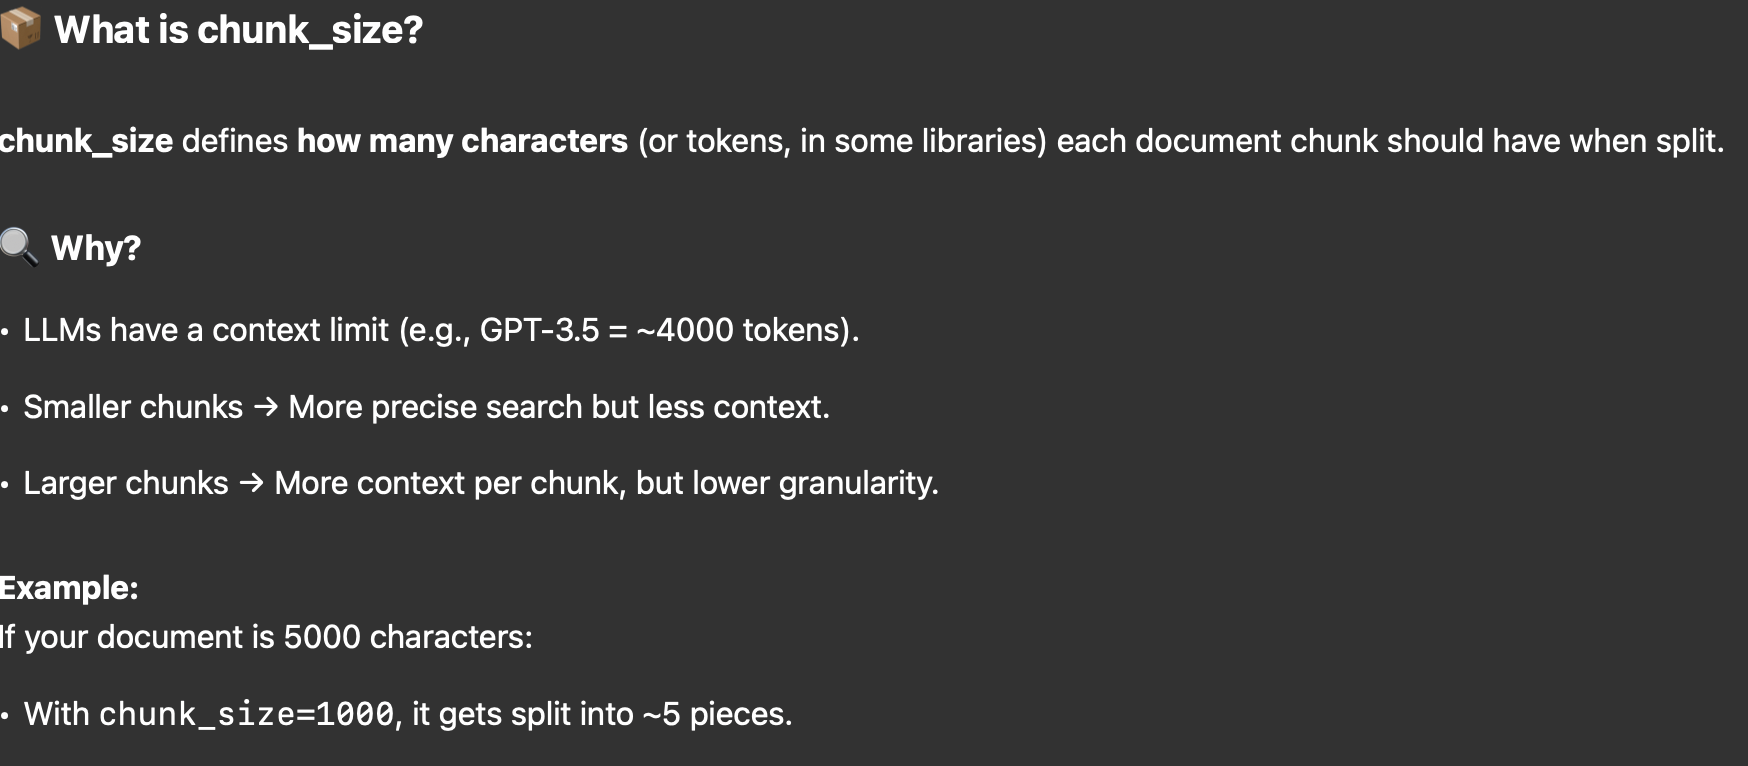

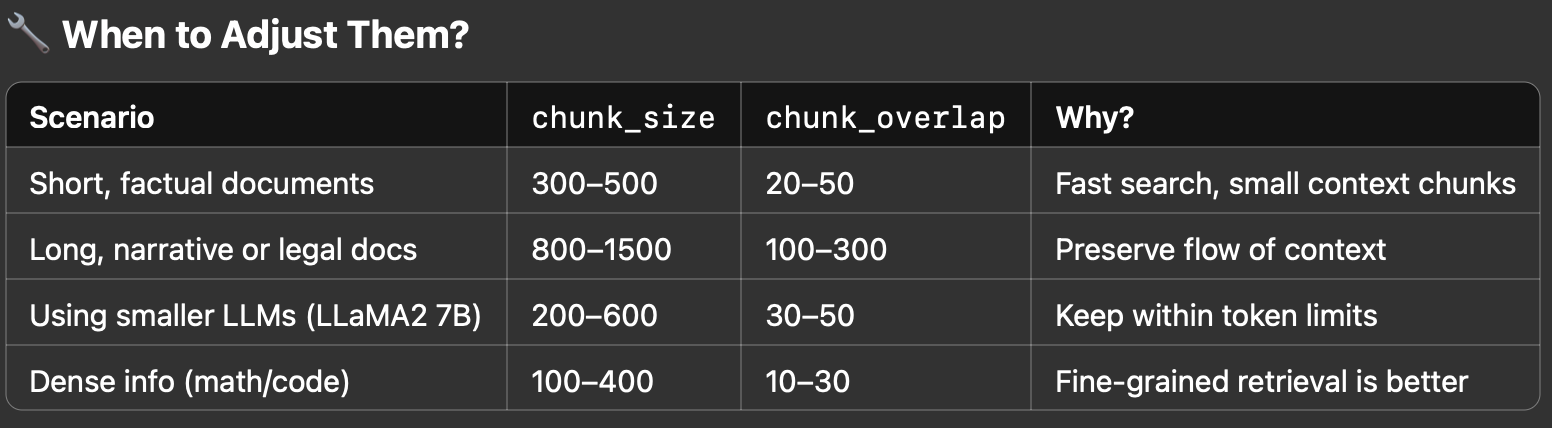

In [18]:
# Split the loaded documents into smaller chunks using recursive character-based splitting
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    separators=["\n\n", "\n", " ", ""]
)

chunks = text_splitter.split_documents(documents)
print(f"Total chunks created: {len(chunks)}")

Total chunks created: 527


In [24]:
# Initialize a sentence-transformer embedding model and index the document chunks using FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedding_model = HuggingFaceEmbeddings(
    model_name="all-MiniLM-L6-v2", 
    encode_kwargs={'normalize_embeddings': True}
)

vectorstores = FAISS.from_documents(chunks, embedding_model)


In [31]:
# Load the FLAN-T5 model from HuggingFace for both query rewriting and generation tasks
from transformers import pipeline

rewriter = pipeline("text2text-generation", model="google/flan-t5-base", max_length=64)
llm = pipeline("text2text-generation", model = "google/flan-t5-base", max_length = 512)

Device set to use mps:0
Device set to use mps:0


In [28]:
# Define a helper function to rewrite vague user queries into more specific and searchable queries
def rewrite_query(raw_query: str) -> str:
    prompt = f"Rewrite this query to make it more specific and clear for a search engine: {raw_query}"
    rewritten = rewriter(prompt)[0]['generated_text']
    return rewritten

In [29]:
# Placeholder for a RAG execution pipeline that uses the rewritten query (to be integrated later)
query = input("Ask your question: ")

# Step 1: Rewrite the vague query
rewritten_query = rewrite_query(query)
print(" Rewritten Query:", rewritten_query)

#  Step 2: Use the rewritten query for RAG
response = rag_chain.run(rewritten_query)
print(" Final Answer:", response)

Ask your question:  adobe vagueness info


🔁 Rewritten Query: adobe vagueness info


NameError: name 'rag_chain' is not defined

In [32]:
class LocalLLMWrapper:
    def __init__(self, pipe):
        self.pipe = pipe

    def __call__(self, prompt: str):
        return self.pipe(prompt)[0]["generated_text"]
    
    def invoke(self, input: str):  # For LangChain-like compatibility
        return self.__call__(input)

In [41]:
# Convert FAISS index into a retriever to fetch relevant chunks for a given query
retriever = vectorstores.as_retriever(search_kwargs={"k": 4})
# Retrieve top-k relevant documents for a test query
retrieved_docs = retriever.get_relevant_documents("give me complete information about ambuiguity detection logic in adobe paper ")

# Format the prompt manually (simple stuffing)
context = "\n\n".join([doc.page_content for doc in retrieved_docs])

final_prompt = f"""Use the following context to answer the question.

Context:
{context}

Question:
What is query vagueness in information retrieval?

Answer:"""

# Generate an answer using the local FLAN-T5 model
llm_wrapper = LocalLLMWrapper(llm)
response = llm_wrapper(final_prompt)
print(" Final Answer:", response)

 Final Answer: Query Length
